## Model Based Submodular Selection
Author: Jacob Schreiber <jmschreiber91@gmail.com>


Submodular selection is the task of identifying a representative subset of samples from a large set, and apricot focuses on the use of these algorithms to identify a good subset of data that can be used for the purpose of training machine learning models. However, submodular functions can also be coupled with a trained machine learning model and a feature attribution algorithm in order to identify the subset of features that the machine learning model thinks are the most important for training. 

In order to understand how this works, let's review the feature based submodular algorithm that's implemented in apricot. These functions greedily add samples to the growing subset that utilize a diversity of features. The equation that the feature based functions optimize is as follows:

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x_{u}) \right)
\end{equation}

In this equation, $U$ is the set of features, or dimensions, of a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$, that have diminishing returns the larger X gets. 

The default implementation in apricot for $m_{u}$ is the identify function $m_{u}(x_{u}) = x_{u}$, meaning that a sample will have the most gain when it has a high feature value in a feature that is not well represented with high values in the already included samples. What if, instead of using the raw feature value, we used the feature ~attribution~ as determined by some attribution algorithm? This would give us a subset of samples that gave a diversity of importanes. 

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import shap

from sklearn.linear_model import LogisticRegression
from shap import LinearExplainer
from apricot import FeatureBasedSelection

Populating the interactive namespace from numpy and matplotlib


Let's start off with creating two clusters of data and seeing what happens when we use a feature based function off of them natively.

In [2]:
X = numpy.concatenate([numpy.random.normal((7, 8), 1, size=(100, 2)), 
                       numpy.random.normal((10, 5), 1, size=(100, 2))])

y = numpy.concatenate([numpy.zeros(100), numpy.ones(100)])

Xi, yi = FeatureBasedSelection(20).fit_transform(X, y)

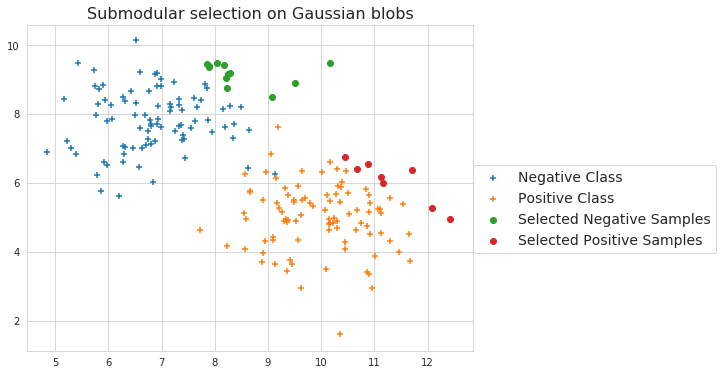

In [3]:
plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:100, 0], X[:100, 1], marker='+', label='Negative Class')
plt.scatter(X[100:, 0], X[100:, 1], marker='+', label='Positive Class')
plt.scatter(Xi[yi == 0, 0], Xi[yi == 0, 1], label='Selected Negative Samples')
plt.scatter(Xi[yi == 1, 0], Xi[yi == 1, 1], label="Selected Positive Samples")

plt.legend(fontsize=14, loc=(1, 0.3))
plt.show()

That's unfortunate. It looks like the selected samples are just those with the highest feature values. This is not entirely true due to the non-linearity that's applied during selection, but an approximation is that as you run a diagonal line with slope y = -x down from the top right corner of the plot, it selected the first 20 points that it hits. This is a downside of using a feature based function natively.

Well, our goal here was not to select on the feature naively, but rather to identify features that a trained machine learning model thought were important. However, this term "important" can have two meanings. It can be the samples that are the most obvious samples from one or another class, perhaps the most representative, or it can be those that are on the boundary. Let's look at the first case first. In order to calculate feature importances we will use the package shap.

The first thing to do is to train our model. In our case let's train a logistic regression model.

In [4]:
model = LogisticRegression().fit(X, y)

Now we need to gt the attributions. These values sum up to the final prediction and atribute to each feature the importance of that measurement.

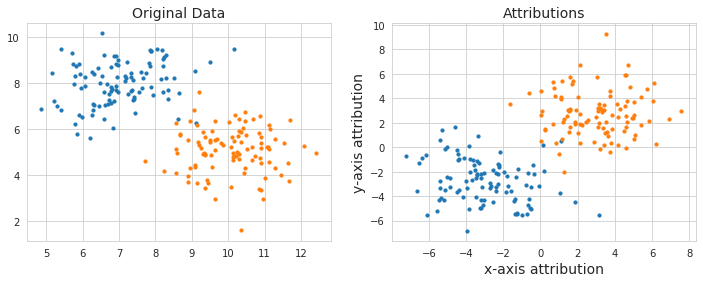

In [5]:
X_shap = LinearExplainer(model, X).shap_values(X)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Original Data", fontsize=14)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10)
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10)

plt.subplot(122)
plt.title("Attributions", fontsize=14)
plt.scatter(X_shap[y == 0, 0], X_shap[y == 0, 1], s=10)
plt.scatter(X_shap[y == 1, 0], X_shap[y == 1, 1], s=10)
plt.xlabel("x-axis attribution", fontsize=14)
plt.ylabel("y-axis attribution", fontsize=14)
plt.show()

Unfortunately these values correspond to the log odds and so can be negative when they are predicting the negative class. We can correct for this by taking the absolute value of the attribution. That will ensure that the values are entirely positive and that the higher in magnitude they are, the most important that feature was for the prediction.

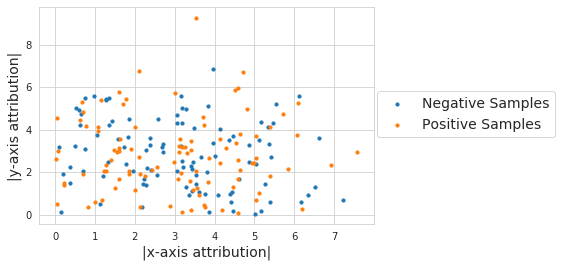

In [6]:
X_shap = numpy.abs(X_shap)

plt.scatter(X_shap[y == 0, 0], X_shap[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X_shap[y == 1, 0], X_shap[y == 1, 1], s=10, label="Positive Samples")
plt.xlabel("|x-axis attribution|", fontsize=14)
plt.ylabel("|y-axis attribution|", fontsize=14)
plt.legend(fontsize=14, loc=(1.01, 0.4))
plt.show()

In this absolute attribution space we will still be selecting values as if you were running a line with slope y = -x down from the top of the plot, but these transformed values should be more amenable to that selection in that manner. Now, let's select the 20 most important samples according to the model. We can compare this to the samples that the model is most confident in, as ranked by maximum predicted probability.

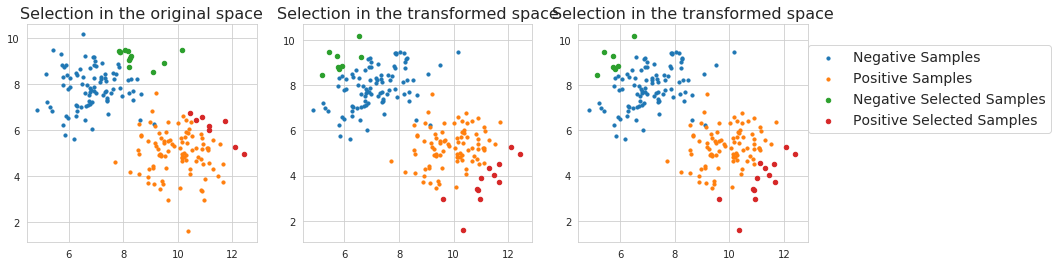

In [7]:
Xi1, yi1 = FeatureBasedSelection(20).fit_transform(X, y)

selector = FeatureBasedSelection(20)
selector.fit_transform(X_shap)
Xi2 = X[selector.ranking]
yi2 = y[selector.ranking]

y_pred = model.predict_proba(X).max(axis=1)
idx = numpy.argsort(y_pred)[::-1][:20]
Xi3 = X[idx]
yi3 = y[idx]

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Selection in the original space", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi1[yi1 == 0, 0], Xi1[yi1 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi1[yi1 == 1, 0], Xi1[yi1 == 1, 1], s=20, label="Positive Selected Samples")

plt.subplot(132)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi2[yi2 == 0, 0], Xi2[yi2 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi2[yi2 == 1, 0], Xi2[yi2 == 1, 1], s=20, label="Positive Selected Samples")

plt.subplot(133)
plt.title("Selection in the transformed space", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi3[yi3 == 0, 0], Xi3[yi3 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi3[yi3 == 1, 0], Xi3[yi3 == 1, 1], s=20, label="Positive Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.5))
plt.show()

It certainly looks like using the absolute attributions in this manner is yielding samples that are more representative of the most confident samples. However, it's unclear what the differences between using attributions versus using the model predictions alone correspond to, and whether one is better than the other in this simple case.

Another way that one might want to select samples is based on the *least confident samples*, i.e., identifying those samples that lie near the decision boundary. This can be particularly useful for the identification of samples that a model would be uncertain about. We can use a similar procedure, but after taking the absolute value of the attribution values, we multiply all attributions for a sample by the *minimum predicted class probability*. This has the effect of reducing values for samples where the model is very confident, while preserving values when the model is uncertain. The submodular selection algorithm will then preferentially select samples that have a diversity of features being relevant for the prediction, but only for uncertain samples.

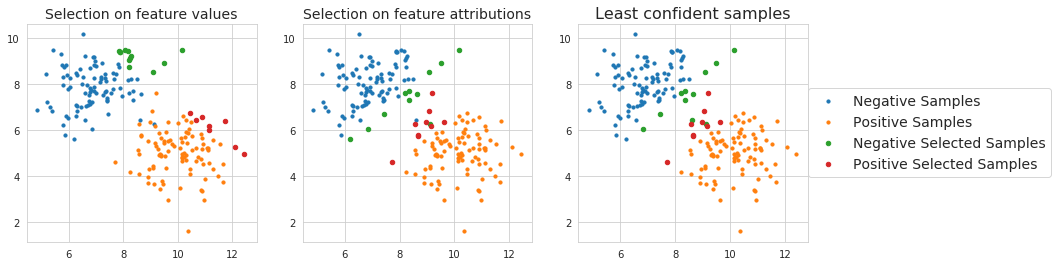

In [8]:
X_shap = LinearExplainer(model, X).shap_values(X)
X_shap = (numpy.abs(X_shap).T * model.predict_proba(X).min(axis=1)).T

Xi1, yi1 = FeatureBasedSelection(20).fit_transform(X, y)

selector = FeatureBasedSelection(20)
selector.fit_transform(X_shap)
Xi2 = X[selector.ranking]
yi2 = y[selector.ranking]

y_pred = model.predict_proba(X).min(axis=1)
idx = numpy.argsort(y_pred)[::-1][:20]
Xi3 = X[idx]
yi3 = y[idx]

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Selection on feature values", fontsize=14)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi1[yi1 == 0, 0], Xi1[yi1 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi1[yi1 == 1, 0], Xi1[yi1 == 1, 1], s=20, label="Positive Selected Samples")

plt.subplot(132)
plt.title("Selection on feature attributions", fontsize=14)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi2[yi2 == 0, 0], Xi2[yi2 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi2[yi2 == 1, 0], Xi2[yi2 == 1, 1], s=20, label="Positive Selected Samples")

plt.subplot(133)
plt.title("Least confident samples", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Positive Samples")
plt.scatter(Xi3[yi3 == 0, 0], Xi3[yi3 == 0, 1], s=20, label="Negative Selected Samples")
plt.scatter(Xi3[yi3 == 1, 0], Xi3[yi3 == 1, 1], s=20, label="Positive Selected Samples")
plt.legend(fontsize=14, loc=(1, 0.3))
plt.show()

It looks like, again, using the attributions is much more meaningful tha running submodular selection on the original feature values. One could argue that it looks like performing submodular selection on the attributions yields a more diverse sampling near the decision boundary than using the those samples that the model is the least confident about, but it's a bit subjective to say that.

Let's try to solidify a situation in which submodular selection on the attribution values is better than selecting the least confident samples. In this case, we'll build a data set where samples overlap significant in one part of the decision boundary and not in another portion.

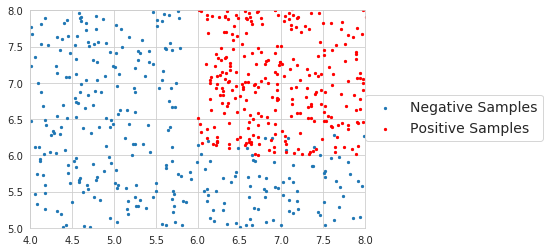

In [9]:
numpy.random.seed(2)

X = numpy.concatenate([numpy.random.uniform((5.6, 5), (8, 6.3), size=(100, 2)),
                       numpy.random.uniform((4, 5), (5.8, 8), size=(200, 2)),
                       numpy.random.uniform(6, 8.1, size=(300, 2))])

y = numpy.concatenate([numpy.zeros(300), numpy.ones(300)])

plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5, label="Negative Samples")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5, label="Positive Samples")
plt.legend(fontsize=14, loc=(1, 0.4))
plt.xlim(4, 8)
plt.ylim(5, 8)
plt.show()

On this data set we can see that the blue and red samples overlap on the portion of the decision boundary where the y-axis separates the two classes, but that the samples don't overlap on the portion where the x-axis separates the two classes. A machine learning model built on this data will be less sure about the overlapping samples 

In [10]:
from sklearn.svm import SVC
from shap import KernelExplainer

model = SVC(probability=True).fit(X, y)
explainer = KernelExplainer(model.predict_proba, X)
X_shap = explainer.shap_values(X, l1_reg="num_features(10)")
X_shap = (numpy.abs(X_shap[1] - X_shap[0]).T * model.predict_proba(X).min(axis=1)).T

selector = FeatureBasedSelection(50)
selector.fit_transform(X_shap)
Xi2 = X[selector.ranking]

y_pred = model.predict_proba(X).min(axis=1)
idx = numpy.argsort(y_pred)[::-1]


xx, yy = np.meshgrid(np.arange(4, 8.1, 0.1), np.arange(5, 9.1, 0.1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Now let's plot the attributions for each sample, the decision boundaries, and the selected samples using submodular selection versus the least confident samples.

linewidths is ignored by contourf
linewidths is ignored by contourf


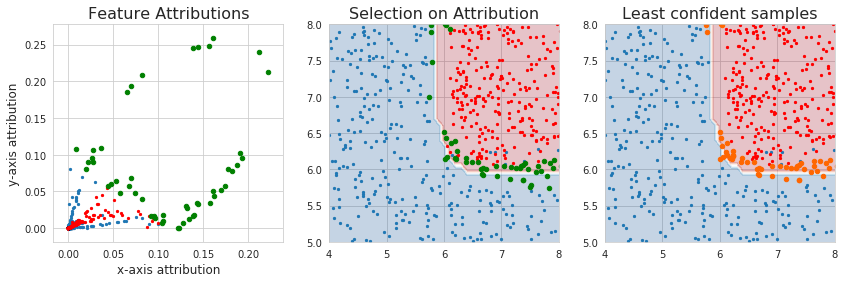

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Feature Attributions", fontsize=16)
plt.scatter(X_shap[y == 0, 0], X_shap[y == 0, 1], s=5)
plt.scatter(X_shap[y == 1, 0], X_shap[y == 1, 1], c='r', s=5)
plt.scatter(X_shap[selector.ranking][:, 0], X_shap[selector.ranking][:, 1], c='g', s=20)
plt.xlabel("x-axis attribution", fontsize=12)
plt.ylabel("y-axis attribution", fontsize=12)

plt.subplot(132)
plt.title("Selection on Attribution", fontsize=16)
plt.contourf(xx, yy, Z, cmap='RdBu_r', linewidths=0.3, alpha=0.25)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5)
plt.scatter(Xi2[:, 0], Xi2[:, 1], s=20, color='g', label="Selected Samples")
plt.xlim(4, 8)
plt.ylim(5, 8)

plt.subplot(133)
plt.title("Least confident samples", fontsize=16)

plt.contourf(xx, yy, Z, cmap='RdBu_r', linewidths=0.3, alpha=0.25)
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', s=5)
plt.scatter(X[idx[:50], 0], X[idx[:50], 1], s=20, color='#FF6600', label="Selected Samples")
plt.xlim(4, 8)
plt.ylim(5, 8)
plt.savefig("img/attributionselection.png")
plt.show()

It looks like here that submodular selection identifies six samples from the x-axis dominated portion of the selection whereas the least confident samples selects only a single one. 